#### pre-processing

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os
# !pip install ptflops
# from ptflops import get_model_complexity_info
# !pip install wget
# import wget
# !pip install requests gdown
# import gdown

In [2]:
# Hyper-parameter and setting
image_size = 28
batch_size = 2048
channel_size = 3
lr = 1e-3
num_epochs_student = 10
num_classes = 10

# var init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(123)

In [3]:
# Data pre-processing of source and target domain
tf_source = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.1307,],  # Normalization as MNIST setting
                        std=[0.30,],
                        )
])

tf_target = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.5, 0.5, 0.5],  # Normalization as default setting
                        std=[0.5, 0.5, 0.5],
                        )
])

########################################################################################
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Dataset and dataloader source & target domain (train_set)
# Ds_source = datasets.MNIST(root='Dataset/mnist_dataset/', download=True, train=True, transform=tf_source)
# Dl_source = DataLoader(Ds_source, batch_size, shuffle=True, num_workers=2)

# Download here: https://drive.google.com/drive/folders/14IgFgyHyJ3I8-VPzzA33sBF1w2E1mVVt?usp=sharing
# Mount and unzip from directory
from google.colab import drive
drive.mount('./drive/')
!unzip './drive/MyDrive/99H_datasets/MNIST_M.zip'
# Upload directly
# !unzip './MNIST_M.zip'

# Ds_target = datasets.ImageFolder(root='./MNIST_M/train', transform=tf_target)
# Dl_target = DataLoader(Ds_target, batch_size, shuffle=True, num_workers=2)
# train_split = 0.8
# train_size = int(train_split * len(Dl_target))
# test_size = len(Dl_target) - train_size
# Dl_tar_training_set, Dl_tar_testing_set = torch.utils.data.random_split(Dl_target, [train_size, test_size])
Ds_target_train = datasets.ImageFolder(root='./MNIST_M/train', transform=tf_target)
Dl_tar_training_set = DataLoader(Ds_target_train, batch_size, shuffle=True, num_workers=2)
Ds_target_test = datasets.ImageFolder(root='./MNIST_M/test', transform=tf_target)
Dl_tar_testing_set = DataLoader(Ds_target_test, batch_size, shuffle=True, num_workers=2)

def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_student_acc"], label="Train")
    ax1.plot(history["val_student_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_student_loss"], label="Train")
    ax2.plot(history["val_student_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

Streaming output truncated to the last 5000 lines.
 extracting: MNIST_M/train/9/00008555.png  
 extracting: MNIST_M/train/9/00008558.png  
 extracting: MNIST_M/train/9/00008563.png  
 extracting: MNIST_M/train/9/00008581.png  
 extracting: MNIST_M/train/9/00008585.png  
 extracting: MNIST_M/train/9/00008586.png  
 extracting: MNIST_M/train/9/00008592.png  
 extracting: MNIST_M/train/9/00008601.png  
 extracting: MNIST_M/train/9/00008608.png  
 extracting: MNIST_M/train/9/00008620.png  
 extracting: MNIST_M/train/9/00008626.png  
 extracting: MNIST_M/train/9/00008630.png  
 extracting: MNIST_M/train/9/00008641.png  
 extracting: MNIST_M/train/9/00008654.png  
 extracting: MNIST_M/train/9/00008669.png  
 extracting: MNIST_M/train/9/00008671.png  
 extracting: MNIST_M/train/9/00008674.png  
 extracting: MNIST_M/train/9/00008702.png  
 extracting: MNIST_M/train/9/00008714.png  
 extracting: MNIST_M/train/9/00008721.png  
 extracting: MNIST_M/train/9/00008736.png  
 extracting: MNIST_M/trai

--------------
#### Pruning
Han, S., Mao, H., & Dally, W. J. (2015). Deep compression: Compressing deep neural networks with pruning, trained quantization and huffman coding. arXiv preprint arXiv:1510.00149.\
Referred doc: https://arxiv.org/abs/1510.00149 \
Example: https://github.com/siyuan0/pytorch_model_prune


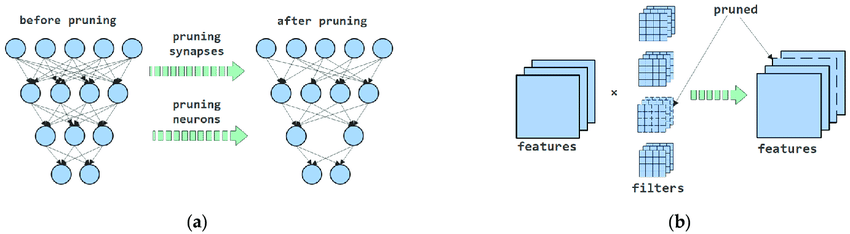

In [4]:
# @title FLOPS computation
# Code from https://github.com/Eric-mingjie/rethinking-network-pruning/blob/master/imagenet/l1-norm-pruning/compute_flops.py
import numpy as np
import os

import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable


def print_model_param_nums(model=None):
    if model == None:
        model = torchvision.models.alexnet()
    total = sum([param.nelement() if param.requires_grad else 0 for param in model.parameters()])
    print('  + Number of params: %.4fM' % (total / 1e6))

def count_model_param_flops(model=None, input_res=224, multiply_adds=True):

    prods = {}
    def save_hook(name):
        def hook_per(self, input, output):
            prods[name] = np.prod(input[0].shape)
        return hook_per

    list_1=[]
    def simple_hook(self, input, output):
        list_1.append(np.prod(input[0].shape))
    list_2={}
    def simple_hook2(self, input, output):
        list_2['names'] = np.prod(input[0].shape)


    list_conv=[]
    def conv_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size[0] * self.kernel_size[1] * (self.in_channels / self.groups)
        bias_ops = 1 if self.bias is not None else 0

        params = output_channels * (kernel_ops + bias_ops)
        # flops = (kernel_ops * (2 if multiply_adds else 1) + bias_ops) * output_channels * output_height * output_width * batch_size

        num_weight_params = (self.weight.data != 0).float().sum()
        flops = (num_weight_params * (2 if multiply_adds else 1) + bias_ops * output_channels) * output_height * output_width * batch_size

        list_conv.append(flops)

    list_linear=[]
    def linear_hook(self, input, output):
        batch_size = input[0].size(0) if input[0].dim() == 2 else 1

        weight_ops = self.weight.nelement() * (2 if multiply_adds else 1)
        bias_ops = self.bias.nelement()

        flops = batch_size * (weight_ops + bias_ops)
        list_linear.append(flops)

    list_bn=[]
    def bn_hook(self, input, output):
        list_bn.append(input[0].nelement() * 2)

    list_relu=[]
    def relu_hook(self, input, output):
        list_relu.append(input[0].nelement())

    list_pooling=[]
    def pooling_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size * self.kernel_size
        bias_ops = 0
        params = 0
        flops = (kernel_ops + bias_ops) * output_channels * output_height * output_width * batch_size

        list_pooling.append(flops)

    list_upsample=[]

    # For bilinear upsample
    def upsample_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        flops = output_height * output_width * output_channels * batch_size * 12
        list_upsample.append(flops)

    def foo(net):
        childrens = list(net.children())
        if not childrens:
            if isinstance(net, torch.nn.Conv2d):
                net.register_forward_hook(conv_hook)
            if isinstance(net, torch.nn.Linear):
                net.register_forward_hook(linear_hook)
            if isinstance(net, torch.nn.BatchNorm2d):
                net.register_forward_hook(bn_hook)
            if isinstance(net, torch.nn.ReLU):
                net.register_forward_hook(relu_hook)
            if isinstance(net, torch.nn.MaxPool2d) or isinstance(net, torch.nn.AvgPool2d):
                net.register_forward_hook(pooling_hook)
            if isinstance(net, torch.nn.Upsample):
                net.register_forward_hook(upsample_hook)
            return
        for c in childrens:
            foo(c)

    if model == None:
        model = torchvision.models.alexnet()
    foo(model)
    input = Variable(torch.rand(3,input_res,input_res).unsqueeze(0), requires_grad = True)
    out = model(input)


    total_flops = (sum(list_conv) + sum(list_linear) + sum(list_bn) + sum(list_relu) + sum(list_pooling) + sum(list_upsample))

    print('Number of FLOPs: %.6f GFLOPs (%.2f MFLOPs)' % (total_flops / 1e9, total_flops / 1e6))

    return total_flops

In [5]:
# # @title Student Model
# ########################################################################################
# class student_model(nn.Module):
#     def __init__(self, f=None, C=None, n_C=10, new_encoder=True, new_classifier=True, class_head=True):
#         super(student_model, self).__init__()
#         self.class_head = class_head
#         self.new_encoder = new_encoder

#         if new_encoder:
#           self.feature_extractor = nn.Sequential(

#               nn.Conv2d(3, 32, kernel_size = 5), # 24
#               nn.BatchNorm2d(32),
#               nn.MaxPool2d(2),        # 12
#               nn.ReLU(),

#               nn.Conv2d(32, 64, kernel_size = 5),  # 8
#               nn.BatchNorm2d(64),
#               nn.MaxPool2d(2),        # 4
#               nn.ReLU(),
#               nn.Dropout2d(),
#           )
#         else:
#           self.feature_extractor = f

#         # Expand from one extractor to two extractor (classed and domain-classed)
#         self.num_cnn_features = 64 * 4 * 4  # 1024 flattening

#         # Label classification (blue section)
#         if new_classifier:
#           self.class_classifier = nn.Sequential(

#               nn.Linear(self.num_cnn_features, 64),
#               nn.BatchNorm1d(64),
#               nn.Dropout(),
#               nn.ReLU(),

#               # output logits layer (10 classes)
#               nn.Linear(64, n_C),
#               nn.LogSoftmax(dim=1),
#           )
#         else:
#           self.class_classifier = C

#     def forward(self, x):

#         # Handle single-channel input by expanding (repeating) the singleton dimension
#         # MNIST (grayscale, 1-channel) to 3-channel
#         x = x.expand(x.data.shape[0], channel_size, image_size, image_size)

#         # Move input tensor to the correct device
#         x = x.to(device)

#         features = self.feature_extractor(x)
#         if self.class_head:
#           features = features.view(-1, self.num_cnn_features) #Flattening
#           class_prediction = self.class_classifier(features)  #regular features classification
#           return  class_prediction
#         else:
#           return features




# # network
# student_fn = student_model(n_C=num_classes).to(device)
# summary(student_fn, input_size=(channel_size, image_size, image_size))
# count_model_param_flops(model=student_fn.eval(), input_res=28, multiply_adds=True)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Residual Block for ResNet-18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Student Model with ResNet-18 Architecture
class student_model(nn.Module):
    def __init__(self, f=None, C=None, n_C=10, new_encoder=True, new_classifier=True, class_head=True):
        super(student_model, self).__init__()
        self.class_head = class_head
        self.new_encoder = new_encoder

        if new_encoder:
            self.in_planes = 64
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
            self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
            self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
            self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

            self.feature_extractor = nn.Sequential(
                self.conv1,
                self.bn1,
                self.maxpool,
                self.layer1,
                self.layer2,
                self.layer3,
                self.layer4,
                self.avgpool
            )
        else:
            self.feature_extractor = f

        self.num_cnn_features = 512  # Output from the last layer

        # Classifier head
        if new_classifier:
            self.class_classifier = nn.Sequential(
                nn.Linear(512, 64),  # Correct input size
                nn.ReLU(),
                nn.Linear(64, n_C),  # n_C is the number of classes
                nn.LogSoftmax(dim=1),
            )
        else:
            self.class_classifier = C

    def _make_layer(self, block, planes, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.expand(x.data.shape[0], 3, x.size(2), x.size(3)).to(device)

        if self.new_encoder:
            x = self.feature_extractor(x)
            x = x.view(x.size(0), -1)  # Flatten
        else:
            # If using an external feature extractor, ensure it's correctly flattened
            x = self.feature_extractor(x)  # This should output [batch_size, 512, 1, 1]
            x = x.view(x.size(0), -1)  # Flatten to [batch_size, 512]

        if self.class_head:
            class_prediction = self.class_classifier(x)
            return class_prediction
        else:
            return x



# Usage
student_fn = student_model(n_C=num_classes, new_encoder=True).to(device)
summary(student_fn, input_size=(3, image_size, image_size))
count_model_param_flops(model=student_fn.eval(), input_res=28, multiply_adds=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
            Conv2d-2           [-1, 64, 14, 14]           9,408
       BatchNorm2d-3           [-1, 64, 14, 14]             128
       BatchNorm2d-4           [-1, 64, 14, 14]             128
         MaxPool2d-5             [-1, 64, 7, 7]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          36,864
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
      BatchNorm2d-10             [-1, 64, 7, 7]             128
           Conv2d-11             [-1, 64, 7, 7]          36,864
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
      BatchNorm2d-14             [-1, 6

tensor(1.3724e+08, device='cuda:0')

In [7]:
# Example input
test_input = torch.randn(2, 3, 28, 28).to(device)  # Batch of 2 images
output = student_fn(test_input)
print("Output shape:", output.shape)  # Should be [2, num_classes]

Output shape: torch.Size([2, 10])


#### Unpruned student net f at layer[0]

In [8]:
# f = student_fn.feature_extractor
# C = student_fn.class_classifier

# # Assume need to prune indexing at layer[0]
# print(f'all params in f[0]: {list(f[0].named_parameters())}'
#       f'\n\n\n buffer in f[0]: {list(f[0].named_buffers())}'
#       f'\n\n\n weights in f[0]: {list(f[0].weight)}'
#       )

# student_fn_unpruned = student_model(f=f, C=C, n_C=num_classes, new_encoder=False, new_classifier=False).to(device)
# summary(student_fn_unpruned, input_size=(3, image_size, image_size))
# count_model_param_flops(model=student_fn_unpruned.eval(), input_res=28, multiply_adds=True)

#### Unstructured pruning f at layer[0]

In [9]:
# # @title RamdomUnstructured --> Weight pruned
# """
# To prune a module (in this example, the conv1 layer of our LeNet architecture),
# first select a pruning technique among those available in torch.nn.utils.prune
# (or implement your own by subclassing BasePruningMethod). Then, specify the module
# and the name of the parameter to prune within that module. Finally, using
# the adequate keyword arguments required by the selected pruning technique,
# specify the pruning parameters.

# In this example, we will prune at random ***30%*** of the connections in the parameter
# named weight in the conv1 layer. The module is passed as the first argument to
# the function; name identifies the parameter within that module using its string
# identifier; and amount indicates either the percentage of connections to prune
# (if it is a float between 0. and 1.), or the absolute number of connections
# to prune (if it is a non-negative integer).
# """

# import torch.nn.utils.prune as prune
# import copy
# # Assume prune layer[0] ---> nn.Conv2d(3, 32, kernel_size = 5)
# f_pruned = copy.deepcopy(f)

# prune.random_unstructured(f_pruned[0], name="weight", amount=0.3)

# print(f'all params in f[0]: {list(f_pruned[0].named_parameters())}'
#       f'\n\n\n buffer in f[0]: {list(f_pruned[0].named_buffers())}'
#       f'\n\n\n weights in f[0]: {f_pruned[0].weight}'
#       f'\n\n\n what is pruning in f[0]: {f_pruned[0]._forward_pre_hooks}'
#       )

# student_fn_pruned = student_model(f=f_pruned, C=C, n_C=num_classes, new_encoder=False, new_classifier=False).to(device)
# summary(student_fn_pruned, input_size=(channel_size, image_size, image_size))
# count_model_param_flops(model=student_fn_pruned.eval(), input_res=28, multiply_adds=True)

In [10]:
# # Assuming f_pruned is already defined and is a list of layers

# # Print parameters to see what exists
# print(f'all params in f[0]: {list(f_pruned[0].named_parameters())}')

# if hasattr(f_pruned[0], 'bias') and f_pruned[0].bias is not None:
#     prune.l1_unstructured(f_pruned[0], name="bias", amount=3)
# else:
#     print("No bias to prune in f_pruned[0].")

# print(f'all params in f[0]: {list(f_pruned[0].named_parameters())}'
#       f'\n\n\n buffer in f[0]: {list(f_pruned[0].named_buffers())}'
#       f'\n\n\n bias in f[0]: {f_pruned[0].bias if hasattr(f_pruned[0], "bias") else None}'
#       f'\n\n\n what is pruning in f[0]: {f_pruned[0]._forward_pre_hooks}'
#       )

# student_fn_pruned = student_model(f=f_pruned, C=C, n_C=num_classes, new_encoder=False, new_classifier=False).to(device)
# summary(student_fn_pruned, input_size=(3, image_size, image_size))
# count_model_param_flops(model=student_fn_pruned, input_res=28, multiply_adds=True)


#### Iterative pruning

In [11]:
# """
# The same parameter in a module can be pruned multiple times, with the effect of
# the various pruning calls being equal to the combination of the various masks
# applied in series. The combination of a new mask with the old mask is handled
# by the PruningContainer’s compute_mask method.

# Say, for example, that we now want to further prune module.weight, this time
# using structured pruning along the 0th axis of the tensor (the 0th axis
# corresponds to the output channels of the convolutional layer and has
# dimensionality 6 for conv1), based on the channels’ L2 norm. This can be
# achieved using the ln_structured function, with n=2 and dim=0.
# """
# # Likewise, prune layer[0] ---> nn.Conv2d(3, 32, kernel_size = 5)
# f_iterpruned = copy.deepcopy(f)

# prune.ln_structured(f_iterpruned[0], name="weight", amount=0.3, n=2, dim=0)

# # As we can verify, this will zero out all the connections corresponding to
# # 30% (~2 out of 6) of the channels, while preserving the action of the
# # previous mask.
# # for hook in f_iterpruned[0]._forward_pre_hooks.values():
# #     if hook._tensor_name == "weight":  # select out the correct hook
# #         break
# print(f'\n\n\n weight in f[0]: {f_iterpruned[0].weight}'
#       f'\n\n\n what is pruning in f[0]: {f_iterpruned[0]._forward_pre_hooks}'
#       ) # pruning history in the container

# student_fn_iterpruned = student_model(f=f_iterpruned, C=C, n_C=num_classes, new_encoder=False, new_classifier=False).to(device)
# summary(student_fn_iterpruned, input_size=(channel_size, image_size, image_size))
# count_model_param_flops(model=student_fn_iterpruned.eval(), input_res=28, multiply_adds=True)

#### Pruning multiple parameters in a model

In [12]:
# """
# By specifying the desired pruning technique and parameters, we can easily prune
# multiple tensors in a network, perhaps according to their type, as we will see
# at below.
# """

# f_multipruned = copy.deepcopy(f)
# for name, module in f_multipruned.named_modules():
#     # prune 20% of connections in all 2D-conv layers
#     if isinstance(module, torch.nn.Conv2d):
#         prune.l1_unstructured(module, name='weight', amount=0.2)
#     # prune 40% of connections in all linear layers
#     elif isinstance(module, torch.nn.Linear):
#         prune.l1_unstructured(module, name='weight', amount=0.4)

# print(dict(f_multipruned.named_buffers()).keys())  # to verify that all masks exist

#### Global pruning

In [17]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_student_acc"], label="Train")
    ax1.plot(history["val_student_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_student_loss"], label="Train")
    ax2.plot(history["val_student_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [18]:
"""
So far, we only looked at what is usually referred to as “local” pruning, i.e.,
the practice of pruning tensors in a model one by one, by comparing the
statistics (weight magnitude, activation, gradient, etc.) of each entry
exclusively to the other entries in that tensor. However, a common and perhaps
more powerful technique is to prune the model all at once, by removing
(for example) the lowest 20% of connections across the whole model, instead of
removing the lowest 20% of connections in each layer. This is likely to result
in different pruning percentages per layer. Let’s see how to do that using
global_unstructured from 'torch.nn.utils.prune.'
"""
import torch.nn.utils.prune as prune
import copy
student_fn_globpruned = student_model(n_C=num_classes).to(device)
f = student_fn_globpruned.feature_extractor
C = student_fn_globpruned.class_classifier
f_allpruned = copy.deepcopy(f)
C_allpruned = copy.deepcopy(C)

# print(len(f_allpruned))
# print(len(C_allpruned))

# parameters_to_prune = (
#     # --- example: in case of self.layer
#     # (f_allpruned.conv1, 'weight'),
#     # (f_allpruned.conv2, 'weight'),
#     # (f_allpruned.fc1, 'weight'),
#     # (f_allpruned.fc2, 'weight'),
#     # (f_allpruned.fc3, 'weight'),
#     # --- example: in case of sequential layer
#     (f_allpruned[0], 'weight'),
#     (f_allpruned[4], 'weight'),
#     (C_allpruned[0], 'weight'),
#     # (C_allpruned[3], 'weight'),
# )

parameters_to_prune = []

# For feature extractor
for i, layer in enumerate(f_allpruned):
    if hasattr(layer, 'weight'):
        parameters_to_prune.append((layer, 'weight'))

# For classifier
for i, layer in enumerate(C_allpruned):
    if hasattr(layer, 'weight'):
        parameters_to_prune.append((layer, 'weight'))

# Pruning the same setting
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2, #amount = [0.1, 0.3, x]
)



# --- example: in case of self.layer
# print(
#     "Sparsity in conv1.weight: {:.2f}%".format(
#         100. * float(torch.sum(f_allpruned.conv1.weight == 0))
#         / float(f_allpruned.conv1.weight.nelement())
#     )
# )
# print(
#     "Sparsity in conv2.weight: {:.2f}%".format(
#         100. * float(torch.sum(f_allpruned.conv2.weight == 0))
#         / float(f_allpruned.conv2.weight.nelement())
#     )
# )
# print(
#     "Sparsity in fc1.weight: {:.2f}%".format(
#         100. * float(torch.sum(f_allpruned.fc1.weight == 0))
#         / float(f_allpruned.fc1.weight.nelement())
#     )
# )
# print(
#     "Sparsity in fc2.weight: {:.2f}%".format(
#         100. * float(torch.sum(f_allpruned.fc2.weight == 0))
#         / float(f_allpruned.fc2.weight.nelement())
#     )
# )
# print(
#     "Sparsity in fc3.weight: {:.2f}%".format(
#         100. * float(torch.sum(f_allpruned.fc3.weight == 0))
#         / float(f_allpruned.fc3.weight.nelement())
#     )
# )
# print(
#     "Global sparsity: {:.2f}%".format(
#         100. * float(
#             torch.sum(f_allpruned.conv1.weight == 0)
#             + torch.sum(f_allpruned.conv2.weight == 0)
#             + torch.sum(f_allpruned.fc1.weight == 0)
#             + torch.sum(f_allpruned.fc2.weight == 0)
#             + torch.sum(f_allpruned.fc3.weight == 0)
#         )
#         / float(
#             f_allpruned.conv1.weight.nelement()
#             + f_allpruned.conv2.weight.nelement()
#             + f_allpruned.fc1.weight.nelement()
#             + f_allpruned.fc2.weight.nelement()
#             + f_allpruned.fc3.weight.nelement()
#         )
#     )
# )
# --- example: in case of sequential layer
# print(
#     "Sparsity in f_allpruned.conv[0].weight: {:.2f}%".format(
#         100. * float(torch.sum(f_allpruned[0].weight == 0))
#         / float(f_allpruned[0].weight.nelement())
#     )
# )
# print(
#     "Sparsity in f_allpruned.conv[4].weight: {:.2f}%".format(
#         100. * float(torch.sum(f_allpruned[4].weight == 0))
#         / float(f_allpruned[4].weight.nelement())
#     )
# )
# print(
#     "Sparsity in C_allpruned.linear[0].weight: {:.2f}%".format(
#         100. * float(torch.sum(C_allpruned[0].weight == 0))
#         / float(C_allpruned[0].weight.nelement())
#     )
# )
# print(
#     "Sparsity in C_allpruned.linear[4].weight: {:.2f}%".format(
#         100. * float(torch.sum(C_allpruned[4].weight == 0))
#         / float(C_allpruned[4].weight.nelement())
#     )
# )

for i, layer in enumerate(f_allpruned):
    if hasattr(layer, 'weight'):
        sparsity = 100. * float(torch.sum(layer.weight == 0)) / float(layer.weight.nelement())
        print(f"Sparsity in f_allpruned[{i}].weight: {sparsity:.2f}%")

for i, layer in enumerate(C_allpruned):
    if hasattr(layer, 'weight'):
        sparsity = 100. * float(torch.sum(layer.weight == 0)) / float(layer.weight.nelement())
        print(f"Sparsity in C_allpruned[{i}].weight: {sparsity:.2f}%")

# print(
#     "Global sparsity: {:.2f}%".format(
#         100. * float(
#             torch.sum(f_allpruned[0].weight == 0)
#             + torch.sum(f_allpruned[4].weight == 0)
#             + torch.sum(C_allpruned[0].weight == 0)
#             + torch.sum(C_allpruned[4].weight == 0)
#         )
#         / float(
#             f_allpruned[0].weight.nelement()
#             + f_allpruned[4].weight.nelement()
#             + C_allpruned[0].weight.nelement()
#             + C_allpruned[4].weight.nelement()
#         )
#     )
# )

total_zero_weights = 0
total_weights = 0

# Accumulate sparsity for feature extractor
for layer in f_allpruned:
    if hasattr(layer, 'weight'):
        total_zero_weights += torch.sum(layer.weight == 0).item()
        total_weights += layer.weight.nelement()

# Accumulate sparsity for classifier
for layer in C_allpruned:
    if hasattr(layer, 'weight'):
        total_zero_weights += torch.sum(layer.weight == 0).item()
        total_weights += layer.weight.nelement()

# Calculate global sparsity
global_sparsity = 100. * total_zero_weights / total_weights
print(f"Global sparsity: {global_sparsity:.2f}%")


student_fn_globpruned = student_model(f=f_allpruned, C=C_allpruned, n_C=num_classes, new_encoder=False, new_classifier=False).to(device)
summary(student_fn_globpruned, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=student_fn_globpruned.eval(), input_res=28, multiply_adds=True)

Sparsity in f_allpruned[0].weight: 11.89%
Sparsity in f_allpruned[1].weight: 0.00%
Sparsity in C_allpruned[0].weight: 22.60%
Sparsity in C_allpruned[2].weight: 7.81%
Global sparsity: 20.00%
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4             [-1, 64, 7, 7]          36,864
       BatchNorm2d-5             [-1, 64, 7, 7]             128
            Conv2d-6             [-1, 64, 7, 7]          36,864
       BatchNorm2d-7             [-1, 64, 7, 7]             128
        BasicBlock-8             [-1, 64, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          36,864
      BatchNorm2d-10             [-1, 64, 7, 7]             128
           Conv2d-11             [-1, 64,

tensor(68212816., device='cuda:0')

#### Student batch running (Non-pruned)

In [19]:
# # Optimizer and cost function
# optimizer = optim.Adam(student_fn.parameters(), lr)
# loss_fn = torch.nn.CrossEntropyLoss()

# ###########################################################################
# # 1st step: Training student net
# t_0 = time.time()
# iter_student = 0
# best_vloss = 1_000_000.
# training_logs_student = {"train_student_loss": [],  "val_student_loss": [], "train_student_acc": [], "val_student_acc": []}
# for epoch in range(num_epochs_student):
#     train_loss, train_correct = 0, 0
#     print(f'epochs {epoch+1:04d} / {num_epochs_student:04d}', end='\n============\n')

#     for i, data in enumerate(Dl_tar_training_set):
#     # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):
#         student_fn.train()
#         # zero parameters gradient to Net and optimizer
#         # model.zero_grad()
#         optimizer.zero_grad()

#         # GPU processing source and target data
#         X, y = data[0].to(device), data[1].to(device)

#         yhat = student_fn(X)
#         loss = loss_fn(yhat, y)                 # source classification loss

#         # back-propagation (reversed grad to maximize domain loss)
#         loss.backward()
#         # optimization tuning
#         optimizer.step()

#         # #output predict from net
#         student_fn.eval()
#         with torch.no_grad():
#           class_prediction = student_fn(X)

#         # print(f'[{i+1}/{len(Dl_tar_training_set)}] '
#         #       f'student class loss: {loss.item():.4f} '
#         #       )
#         # if batch_idx == 50:
#         #     print('This is just a demo, stopping...')
#         #     break

#         train_loss += loss.item()
#         train_correct += (class_prediction.argmax(1) == y).float().sum().item()

#     training_logs_student["train_student_loss"].append(train_loss / len(Dl_tar_training_set))
#     training_logs_student["train_student_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

#     running_vloss = 0.0
#     # Set the model to evaluation mode, disabling dropout and using population
#     # statistics for batch normalization.
#     student_fn.eval()
#     # Disable gradient computation and reduce memory consumption.
#     valid_loss, valid_correct = 0, 0
#     with torch.no_grad():
#         for i, vdata in enumerate(Dl_tar_testing_set):
#             vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
#             voutputs = student_fn(vinputs)
#             vloss = loss_fn(voutputs, vlabels)
#             valid_loss += loss_fn(voutputs, vlabels).item()
#             valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
#         # save testing logs
#         training_logs_student["val_student_loss"].append(valid_loss / len(Dl_tar_testing_set))
#         training_logs_student["val_student_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

#     if epoch % 1 == 0:
#         print(f"Epochs {epoch+1}".ljust(10),
#             f"train loss {training_logs_student['train_student_loss'][-1]:.5f}",
#             f"train acc {training_logs_student['train_student_acc'][-1]:.5f}",

#             f"validate loss {training_logs_student['val_student_loss'][-1]:.5f}",
#             f"validate acc {training_logs_student['val_student_acc'][-1]:.5f}",
#             )
#         print("-"*80)

#     # Track best performance, and save the model's state
#     if valid_loss < best_vloss:
#         best_vloss = valid_loss
#         # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
#         path_save_cp = './cp/'
#         if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
#         torch.save(student_fn.state_dict(), path_save_cp+'best_unpruned_student_model.pth')

#     iter_student += 1

# t_end = time.time()-t_0
# print(f"Time consumption for student net (device:{device}): {t_end} sec")

# plot_graph(training_logs_student)

#### Student batch running (Global simple pruned)

epochs 0001 / 0010
Epochs 1   train loss 0.90818 train acc 0.53364 validate loss 0.38573 validate acc 0.87135
--------------------------------------------------------------------------------
epochs 0002 / 0010
Epochs 2   train loss 0.24519 train acc 0.91470 validate loss 0.23516 validate acc 0.92156
--------------------------------------------------------------------------------
epochs 0003 / 0010
Epochs 3   train loss 0.15232 train acc 0.95227 validate loss 0.21871 validate acc 0.92845
--------------------------------------------------------------------------------
epochs 0004 / 0010
Epochs 4   train loss 0.10806 train acc 0.96470 validate loss 0.20107 validate acc 0.93890
--------------------------------------------------------------------------------
epochs 0005 / 0010
Epochs 5   train loss 0.08040 train acc 0.97148 validate loss 0.23634 validate acc 0.92867
--------------------------------------------------------------------------------
epochs 0006 / 0010
Epochs 6   train loss 0.05

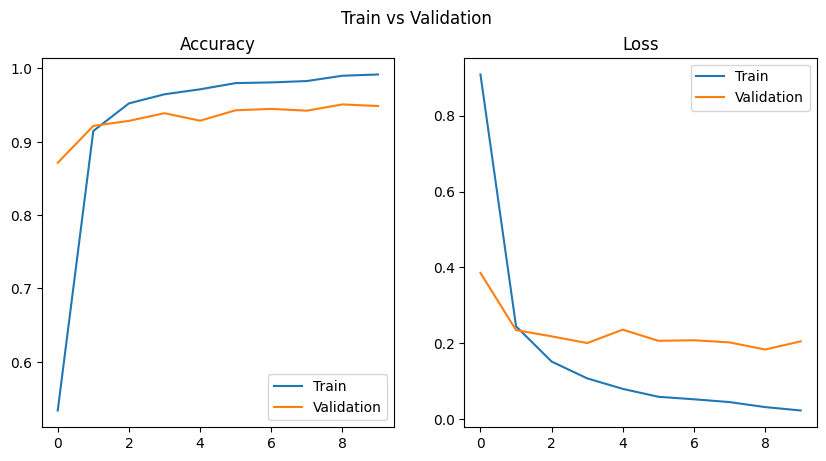

In [20]:
# Optimizer and cost function
optimizer = optim.Adam(student_fn_globpruned.parameters(), lr)
loss_fn = torch.nn.CrossEntropyLoss()

###########################################################################
# 1st step: Training student net
t_0 = time.time()
iter_student = 0
best_vloss = 1_000_000.
training_logs_student = {"train_student_loss": [],  "val_student_loss": [], "train_student_acc": [], "val_student_acc": []}
for epoch in range(num_epochs_student):
    train_loss, train_correct = 0, 0
    print(f'epochs {epoch+1:04d} / {num_epochs_student:04d}', end='\n============\n')

    for i, data in enumerate(Dl_tar_training_set):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):
        student_fn_globpruned.train()
        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()

        # GPU processing source and target data
        X, y = data[0].to(device), data[1].to(device)

        yhat = student_fn_globpruned(X)
        loss = loss_fn(yhat, y)                 # source classification loss

        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()

        # #output predict from net
        student_fn_globpruned.eval()
        with torch.no_grad():
          class_prediction = student_fn_globpruned(X)

        # print(f'[{i+1}/{len(Dl_tar_training_set)}] '
        #       f'student class loss: {loss.item():.4f} '
        #       )
        # if batch_idx == 50:
        #     print('This is just a demo, stopping...')
        #     break

        train_loss += loss.item()
        train_correct += (class_prediction.argmax(1) == y).float().sum().item()

    training_logs_student["train_student_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs_student["train_student_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    student_fn.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = student_fn_globpruned(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs_student["val_student_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs_student["val_student_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs_student['train_student_loss'][-1]:.5f}",
            f"train acc {training_logs_student['train_student_acc'][-1]:.5f}",

            f"validate loss {training_logs_student['val_student_loss'][-1]:.5f}",
            f"validate acc {training_logs_student['val_student_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(student_fn_globpruned.state_dict(), path_save_cp+'best_pruned_student_model.pth')

    iter_student += 1

t_end = time.time()-t_0
print(f"Time consumption for student net (device:{device}): {t_end} sec")

plot_graph(training_logs_student)

# Summary
Pruning is a technique employed to compress machine learning models by selectively removing parts of the network that are deemed unnecessary. Specifically, it involves cutting away certain neural connections or layers that contribute little to the model's performance. Despite these reductions, pruning helps maintain the model’s overall accuracy and effectiveness, thereby lowering computational requirements and improving efficiency. This approach allows for a leaner, faster model without sacrificing its ability to deliver high-quality results.

# Homework
จงบีบอัดแบบ global pruning ไปยัง ResNet-18 (FLOPs: ~1.8 G) (Referred model in W4-2) โดยบีบอัดที่ระดับ

```
amount = [0.1, 0.3, x]
```
 หมายเหตุ: โดยที่ระดับ x บีบอัดแบบ quantization จน

*   ให้มีประสิทธิภาพความแม่นยำ (%acc) ลดลงได้ไม่เกิน -0.01 % หรือใกล้เคียงเมื่อเปรียบเทียบกับแบบ unpruned student
*   แต่สามารถลดการคำนวณของ FLOPs ลงได้ถึง 2 เท่าหรือใกล้เคียง


 โดยให้ตั้งค่า hyper-parameter ทั้งก่อนและหลังบีบอัดที่ setting เดียวกัน สามารถปรับแต่งอิสระในส่วนของ

*   วิธีการ pruning
*   Layer ที่ทำการ pruning
*   ระดับการ pruning (amount)


```
# Pruning layers (assign by urself)
parameters_to_prune = (
    # --- example: in case of self.layer
    # (f_allpruned.XXXX, 'weight'),
    .
    .
    .
    # (f_allpruned.XXXX, 'weight'),
    # --- example: in case of sequential layer
    (f_allpruned[X], 'weight'),
    .
    .
    .
    (f_allpruned[X], 'weight'),
)

# Pruning structures (assign by urself)
prune.ln_structured(
    parameters_to_prune,
    name="weight",
    amount=XXXXXXXX,  <--- assign by urself
    n=2,
    dim=0)
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.XXXXXXXXX,   <--- assign by urself
    amount=XXXXXXXX,  <--- assign by urself
)
```

จัดส่งเป็น PDF ที่เปรียบเทียบผลระหว่าง unpruned student กับ pruned student แบบต่าง ๆ เปรียบเทียบเชิง

*   Quantitative and visualization results (acc., loss, precision, recall, F1, confusion matrix, etc.)
*   Sparsity in each pruned layer & Global sparsity
*   Computational resource in use (training time, parameters, FLOPs, etc.)
